# Computing saliency masks with the PAIRML saliency library

This notebook demonstrates a number of saliency mask techniques, augmented with the `SmoothGrad` technique, using the Inception V3 convolutional neural network. The intention of this notebook is to have as few dependencies as possible to show how to compute masks.

This notebook shows the following techniques, alongside with the `SmoothGrad` augmentation:

*   Vanilla Gradients
    ([paper](https://scholar.google.com/scholar?q=Visualizing+higher-layer+features+of+a+deep+network&btnG=&hl=en&as_sdt=0%2C22),
    [paper](https://arxiv.org/abs/1312.6034))
*   Guided Backpropogation ([paper](https://arxiv.org/abs/1412.6806))
*   Integrated Gradients ([paper](https://arxiv.org/abs/1703.01365))
*   Occlusion

This notebook assumes you have `tensorflow`, `Pillow` and `matplotlib` installed. To install you can run (use `pip` for python 2.x):
```
pip3 install tensorflow --user
pip3 install Pillow --user
pip3 install matplotlib --user
```

In [1]:
# Boilerplate imports.
import tensorflow as tf
import numpy as np
import PIL.Image
from matplotlib import pylab as P
import pickle
import os
import tensorflow.contrib.slim as slim
from tensorflow.contrib.framework import get_or_create_global_step


if not os.path.exists('models/slim'):
  !git clone https://github.com/tensorflow/models/
old_cwd = os.getcwd()
os.chdir('models/slim')
from nets import inception_v3
os.chdir(old_cwd)

# From our repository.
from saliency import SaliencyMask
from saliency import GradientSaliency
from guided_backprop import GuidedBackprop
from integrated_gradients import IntegratedGradients
from occlusion import Occlusion
import visualization

%matplotlib inline

Cloning into 'models'...
remote: Counting objects: 5836, done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 5836 (delta 4), reused 8 (delta 1), pack-reused 5824
Receiving objects: 100% (5836/5836), 157.18 MiB | 2.61 MiB/s, done.
Resolving deltas: 100% (2934/2934), done.


### Utility methods

In [2]:
# Boilerplate methods.
def ShowImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')
  im = ((im + 1) * 127.5).astype(np.uint8)
  P.imshow(im)
  P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
  if ax is None:
    P.figure()
  P.axis('off')

  P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
  P.title(title)

def ShowDivergingImage(grad, title='', percentile=99, ax=None):  
  if ax is None:
    fig, ax = P.subplots()
  else:
    fig = ax.figure
  
  P.axis('off')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad=0.05)
  im = ax.imshow(grad, cmap=P.cm.coolwarm, vmin=-1, vmax=1)
  fig.colorbar(im, cax=cax, orientation='vertical')
  P.title(title)

def LoadImage(file_path):
  im = PIL.Image.open(file_path)
  im = np.asarray(im)
  return im / 127.5 - 1.0

### Loading the Inception model graph

Run the following cell to download the network. Alternatively, the pretrained network can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). Unpack the tensorflow_inception_graph.pb file from the archive and set its path to model_fn variable.

In [3]:
# Use either wget or curl depending on your OS.
if not os.path.exists('inception_v3.ckpt'):
  #!wget http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
  !curl -O http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz
  !tar -xvzf inception_v3_2016_08_28.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 96.2M  100 96.2M    0     0  3327k      0  0:00:29  0:00:29 --:--:-- 3231k
x inception_v3.ckpt


### Adding a single logit tensor for which we want to compute the mask

In [4]:
graph = tf.Graph()

with graph.as_default():
  images = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

  with slim.arg_scope(inception_v3.inception_v3_arg_scope()):
    _, end_points = inception_v3.inception_v3(images, is_training=False, num_classes=1001)
    
    # Restore the checkpoint
    sess = tf.Session(graph=graph)
    saver = tf.train.Saver()
    saver.restore(sess, './inception_v3.ckpt')
    
  # Construct the scalar neuron tensor.
  logits = graph.get_tensor_by_name('InceptionV3/Logits/SpatialSqueeze:0')
  neuron_selector = tf.placeholder(tf.int32)
  y = logits[0][neuron_selector]
    
  # Construct tensor for predictions.
  prediction = tf.argmax(logits, 1)

INFO:tensorflow:Restoring parameters from ./inception_v3.ckpt


### Load an image and infer

Prediction class: 237


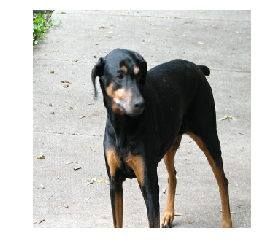

In [5]:
# Load the image
im = LoadImage('./doberman.png')

# Show the image
ShowImage(im)

# Make a prediction. 
prediction_class = sess.run(prediction, feed_dict = {images: [im]})[0]

print("Prediction class: " + str(prediction_class))  # Should be a doberman, class idx = 237

### Vanilla Gradient & SmoothGrad

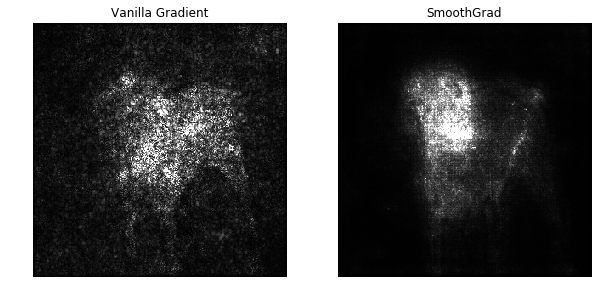

In [6]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
gradient_saliency = GradientSaliency(graph, sess, y, images)

# Compute the vanilla mask and the smoothed mask.
vanilla_mask_3d = gradient_saliency.GetMask(im, feed_dict = {neuron_selector: prediction_class})
smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, feed_dict = {neuron_selector: prediction_class})

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = visualization.VisualizeImageGrayscale(vanilla_mask_3d)
smoothgrad_mask_grayscale = visualization.VisualizeImageGrayscale(smoothgrad_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 2))

### Guided Backprop & SmoothGrad

INFO:tensorflow:Restoring parameters from /tmp/guided_backprop_ckpt


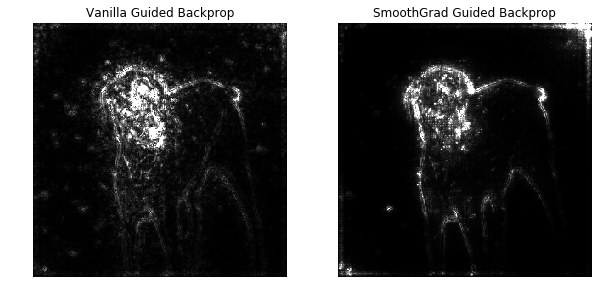

In [7]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
# NOTE: GuidedBackprop creates a copy of the given graph to override the gradient.
# Don't construct too many of these!
guided_backprop = GuidedBackprop(graph, sess, y, images)

# Compute the vanilla mask and the smoothed mask.
vanilla_guided_backprop_mask_3d = guided_backprop.GetMask(
  im, feed_dict = {neuron_selector: prediction_class})
smoothgrad_guided_backprop_mask_3d = guided_backprop.GetSmoothedMask(
  im, feed_dict = {neuron_selector: prediction_class})

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = visualization.VisualizeImageGrayscale(vanilla_guided_backprop_mask_3d)
smoothgrad_mask_grayscale = visualization.VisualizeImageGrayscale(smoothgrad_guided_backprop_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Guided Backprop', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad Guided Backprop', ax=P.subplot(ROWS, COLS, 2))

## Integrated Gradients & SmoothGrad

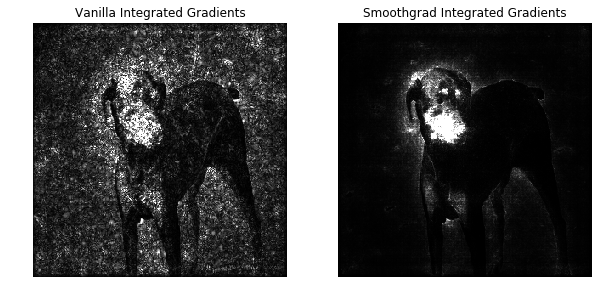

In [8]:
# Construct the saliency object. This doesn't yet compute the saliency mask, it just sets up the necessary ops.
integrated_gradients = IntegratedGradients(graph, sess, y, images)

# Baseline is a black image.
baseline = np.zeros(im.shape)
baseline.fill(-1)

# Compute the vanilla mask and the smoothed mask.
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, feed_dict = {neuron_selector: prediction_class}, x_baseline=baseline)
# Smoothed mask for integrated gradients will take a while since we are doing nsamples * nsamples computations.
smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  im, feed_dict = {neuron_selector: prediction_class}, x_baseline=baseline)

# Call the visualization methods to convert the 3D tensors to 2D grayscale.
vanilla_mask_grayscale = visualization.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
smoothgrad_mask_grayscale = visualization.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

# Set up matplot lib figures.
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))